# Processing taxaonomic/functional profiles generated from metaphlan2
1. Taxonomy profiles were obtained using metaphlan2 with default settings
2. Functional profiles were generated through humann2 with default settings

In [5]:
import numpy as np 
import biom
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Filter out samples based on reads number and metadata

In [6]:
## load the count read files,average should be around 40 million reads 
# minimum threashold to keep is 1 million reads 

df_count=pd.read_csv('./data/sample_reads_count.txt',header=None)

# create a dictionary that store the number of reads 
dic_count={}
for i in range(0,len(df_count[0]),2): 
    dic_count[df_count.loc[i][0]]=int(df_count.loc[i+1][0] )
print 'number of total samples with reads: ',len(dic_count)
    

# filter out samples with few reads 
sample_filter=[]
sample_keep=[]
for k in dic_count.keys(): 
    if dic_count[k]<1000000: 
        sample_filter.append(k)
    else: 
        sample_keep.append(k)
print 'number of samples with greater than 1 million paried reads: ', len(sample_keep)


number of total samples with reads:  325
number of samples with greater than 1 million paried reads:  302


In [7]:
# keep only samples with metadata available 
df_meta=pd.read_csv('./data/metadata_updated_filtered_201904.csv',index_col=0)
sample_metadata=[i for i in sample_keep if i in df_meta.index]
print 'number of samples with metadata available: ', len(sample_metadata)


number of samples with metadata available:  301


In [8]:
#filter out the samples with few reads in taxonomy profiles 

df_tax=pd.read_csv('./data/metaphlan_merged_abundance_new.txt',sep='\t',index_col=0)
print df_tax.shape
sample_overlap=[i for i in sample_metadata if i in df_tax.columns]
df_tax=df_tax[sample_overlap]
print df_tax.shape


(1280, 326)
(1280, 301)


## Save abundance of species, genus, family to separate files

In [9]:
# extract and save taxonomy abundance at species level 
ind_species=[]

for i in df_tax.index: 
    if '|s__' in i and '|t__' not in i: 
        ind_species.append(i)

df_species=df_tax.loc[ind_species]
print df_species.shape
#df_species.to_csv('./data/metaphlan2_species_level_abundance.csv')

(503, 301)


In [10]:
# filter out unclassified species 
spe_keep=[]

for s in df_species.index: 
    if not 'unclassified' in s: 
        spe_keep.append(s)
df_species_cla=df_species.loc[spe_keep]

print df_species_cla.shape
#df_species_cla.to_csv('./data/metaphlan2_species_level_abundance_classified.csv')

(440, 301)


In [11]:
## extract and save taxonomy abundance at genus level 
ind_genus=[]

for i in df_tax.index: 
    if '|g__' in i and '|s__' not in i: 
        ind_genus.append(i)
        
df_genus=df_tax.loc[ind_genus]
print df_genus.shape
#df_genus.to_csv('./data/metaphlan2_genus_level_abundance.csv')

(173, 301)


In [12]:
## extract and save taxonomy abundance at family level 
ind_family=[]

for i in df_tax.index: 
    if '|f__' in i and '|g__' not in i: 
        ind_family.append(i)
        
df_family=df_tax.loc[ind_family]
print df_family.shape
#df_family.to_csv('./data/metaphlan2_family_level_abundance.csv')

(67, 301)


## Filter for samples, organize and save functional profiles


In [13]:
## load the normalize and combined profiles - here we are focused on working with unstratified pathway abundance 
df_pathabund=pd.read_csv('./data/Normalized_cpm_pathabund_new_unstratified.tsv',index_col=0,header=0,sep='\t')

# drop the unintegrated and unmapped 
df_pathabund=df_pathabund.drop(['UNMAPPED','UNINTEGRATED'])

#change the nameos the index 
new_ind=[i.split('_Abundance')[0] for i in df_pathabund.columns]
df_pathabund.columns=new_ind

# only keep the samples with enough reads and metadata generated previous 

# remove one sample from the list: PLCL22244
sample_overlap.remove('PLCL22244')
df_pathabund=df_pathabund[sample_overlap]
#df_pathabund.to_csv('./data/Filtered_normalized_cpm_pathway_new_unstratified.csv')


## Differential species analysis between surgery/non-surgery group 

### ANCOM result plot for taxonomy profiles

Actual calculation done in a separate python3 notebook. 
Here's the ploting script

In [14]:
# split samples into surgery/non-surgery group

dic_surgery=dict(zip(df_meta.index,df_meta.surgery_type))
sample_surgery=[s for s in dic_surgery.keys() if (dic_surgery[s]!='none') and (s in df_species_cla.columns)]
sample_nosurgery=[s for s in df_species_cla.columns if s not in sample_surgery]
print len(sample_surgery)
print len(sample_nosurgery)


92
209


In [16]:
# load the centered log-ratio of top10 differentiating species
df_top10=pd.read_csv('./data/top10_differentiating_species_clr.csv',index_col=0)
ticks=[i.split('|')[-1] for i in df_top10.columns]
ticks=[i.strip('s_') for i in ticks]
ticks=[i.replace('_',' ') for i in ticks]

df_top10.columns=ticks


surgery_label=[]
for i in df_top10.index: 
    if dic_surgery[i]=='none': 
        surgery_label.append('No')
    else: 
        surgery_label.append('Yes')


Text(0.5,0,'Relative abundance (centered log-ratio)')

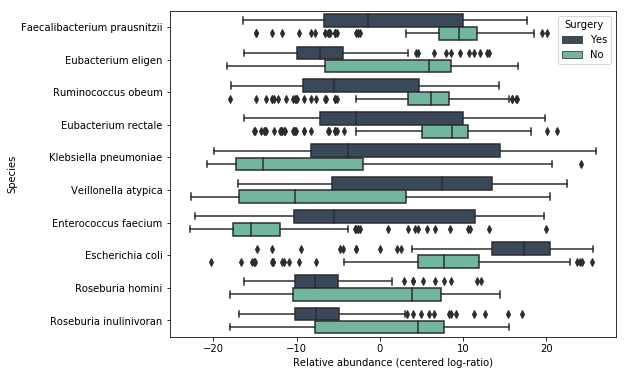

In [17]:
import seaborn as sns 
# flatten the dataframe for plotting purpose
df_top10_new = pd.melt(df_top10)

## add the surgery label to the flattened dataframe 
surgery_label2=[]
for i in range(0,10):
    for i in surgery_label: 
        surgery_label2.append(i)
df_top10_new['Surgery']=surgery_label2
#sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(y="variable", x="value", hue="Surgery",data=df_top10_new,orient='h',palette=['#34495e','#66c2a5'])
plt.ylabel('Species')
plt.xlabel('Relative abundance (centered log-ratio)')
#fig.savefig('../data/Sandborn_data/figures/top 10 differentially-abundant species.svg')
#fig.savefig('../data/Sandborn_data/figures/top 10 differentially-abundant species.pdf')

### ANCOM result plot for functional profiles

Actual calculation done in a separate python3 notebook. 
Here's the ploting script

In [18]:
# split samples into surgery/non-surgery group

sample_surgery_pw=[s for s in dic_surgery.keys() if (dic_surgery[s]!='none') and (s in df_pathabund.columns)]
sample_nosurgery_pw=[s for s in df_pathabund.columns if s not in sample_surgery_pw]
print len(sample_surgery_pw)
print len(sample_nosurgery_pw)

92
208


In [19]:
# load the centered log-ratio of top10 differentiating pathways
df_top10_pw=pd.read_csv('./data/top10_differentiating_pathway_clr.csv',index_col=0)
ticks=[i.split('|')[-1] for i in df_top10_pw.columns]
ticks=[i.split(':')[-1] for i in ticks]
df_top10_pw.columns=ticks

surgery_label_pw=[]
for i in df_top10_pw.index: 
    if dic_surgery[i]=='none': 
        surgery_label_pw.append('No')
    else: 
        surgery_label_pw.append('Yes')


Text(0.5,0,'Relative abundance (centered log-ratio)')

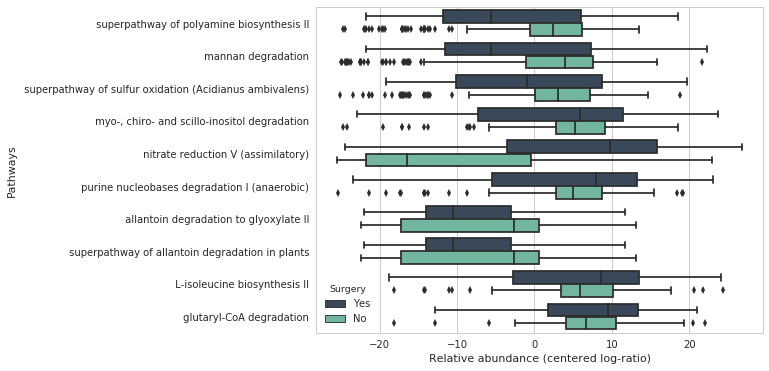

In [20]:
import seaborn as sns 
# flatten the dataframe for plotting purpose
df_top10_new_pw = pd.melt(df_top10_pw)

## add the surgery label to the flattened dataframe 
surgery_label2_pw=[]
for i in range(0,10):
    for i in surgery_label_pw: 
        surgery_label2_pw.append(i)
df_top10_new_pw['Surgery']=surgery_label2_pw

sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(y="variable", x="value", hue="Surgery",data=df_top10_new_pw,orient='h',palette=['#34495e','#66c2a5'])
plt.ylabel('Pathways')
plt.xlabel('Relative abundance (centered log-ratio)')
#fig.savefig('../data/Sandborn_data/figures/top 10 differentially-abundant pathways.svg')
#fig.savefig('../data/Sandborn_data/figures/top 10 differentially-abundant pathways.pdf')